### Description
Dans ce fichier, nous entraînons nos données à l’aide de différents algorithmes de classification (Arbre de décision, Bagging, AdaBoost, Gradient Boosting – GBoost, Forêt d’arbres aléatoires et Classification bayésienne naïve) afin d’analyser et de comparer leurs performances.

### Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

### Fonctions d'implémentation

In [2]:
#Entrainement du modele
def apply_algorithm(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
#Evaluation des metrics et stockage des resultats dans un dataframe
def evaluate_metrics(y_test, y_pred, model_name):
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    F_score = 2 * (precision * TPR) / (precision + TPR) if (precision + TPR) != 0 else 0

    df = pd.DataFrame({
        "TPR": [TPR.round(2)],
        "FPR": [FPR.round(2)],
        "F1-score": [F_score.round(2)]
    }, index=[model_name])
    
    return df

### Lecture et prétraitement des données

In [3]:
# Lecture des données
user_account = pd.read_csv("../data/user_account.csv")

#Normalisation des colonnes
colsToNormalize = ['LengthOfScreenName', 'LengthOfDescriptionInUserProfile', 'LifetimeAccountInMonth',
                'NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets', 'FollowingFollowerRatio',
                'MeanTweetsPerDay', 'UrlInTweetsRate', 'UserMentionsRate', 'MeanTimeSecBetweenTweets',
                'MaxTimeSecBetweenTweets', 'MeanNbMentionsPerTweet','MeanJaccardSimilarity']
user_account[colsToNormalize] = user_account[colsToNormalize].apply(zscore)

user_account

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,LifetimeAccountInMonth,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,FollowingFollowerRatio,MeanTweetsPerDay,UrlInTweetsRate,UserMentionsRate,MeanTimeSecBetweenTweets,MaxTimeSecBetweenTweets,MeanNbMentionsPerTweet,MeanJaccardSimilarity,TypeOfUser
0,6301,-0.995837,1.488501,5.373951,0.448893,0.059528,-0.183837,-0.173776,-0.499581,0.486651,-0.134173,-0.149955,-0.263767,0.058259,-0.068085,1
1,10836,-0.633517,1.527049,6.019570,0.138977,-0.028355,-0.300491,-0.098064,-0.582326,0.412761,-0.640136,0.348902,1.783363,0.058259,0.327210,1
2,10997,0.453443,1.989630,5.696761,-0.055894,0.313108,6.762730,-0.224612,1.362185,-0.424648,0.776562,-0.209222,-0.325072,0.058259,-0.265733,1
3,633293,0.091123,1.276484,4.889737,0.191804,0.173645,1.994394,-0.211633,-0.209973,-0.276870,0.270598,-0.196771,-0.316485,0.058259,-0.463380,1
4,717883,-1.720477,0.293500,4.889737,1.496504,0.212224,-0.181632,-0.171613,-0.251346,0.609799,-0.673867,-0.184887,-0.238989,0.058259,0.129562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39848,93390990,0.091123,-1.055695,-0.920833,-0.317445,-0.058949,-0.341091,-0.231102,-0.458209,0.905355,-0.943715,-0.211228,-0.336302,-0.279067,0.623681,0
39849,93402679,0.453443,-1.055695,-0.920833,-0.313923,-0.058910,-0.341826,0.850509,-0.623699,-1.065021,-0.943715,-0.212854,-0.337231,-0.279067,-0.759852,0
39850,93419256,-0.995837,-1.055695,-0.920833,-0.318618,-0.058949,-0.341826,-0.231102,-0.623699,-1.065021,-0.943715,-0.212854,-0.337231,-0.279067,-0.759852,0
39851,93426370,-0.271197,-1.055695,-0.920833,-0.313923,-0.058910,-0.341826,0.850509,-0.623699,-1.065021,-0.943715,-0.212854,-0.337231,-0.279067,-0.759852,0


In [4]:
#Separation des caracteristiques et de la variable cible
X = user_account.drop(columns=['UserID', 'TypeOfUser'])
y = user_account['TypeOfUser']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Initialisation des algorithmes de classification

In [5]:
#Initialisation de l'arbre de decision
decision_tree = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)

# Initialisation du Bagging avec l'arbre de decision comme estimateur
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),  # Estimateur
    n_estimators=50,  # Nombre d'arbres
    max_samples=0.8,  # Pourcentage de donnee d'entrainement par arbre
    max_features=1.0,  # Pourcentage des caracteristiques par arbre
    bootstrap=True,  # tirage avec remise
    random_state=42
)

# Initialisation AdaBoost avec l'arbre de decision comme estimateur
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=50,  # Nombre d'arbres
    learning_rate=0.1,  # Taille de pas
    random_state=42
)

# Initialisation du Boosting de Gradient avec l'arbre de decision comme estimateur
gboost = GradientBoostingClassifier(
    n_estimators=50,  # Nombre d'arbres
    learning_rate=0.1,  # Taille de pas
    max_depth=5,  # Profondeur des arbres
    random_state=42
)

# Initialisation  des forets aleatoires
random_forest = RandomForestClassifier(
    n_estimators=50,  # Nombre d'arbres
    max_depth=5,     # Profondeur des arbres
    random_state=42 
)

# Initialisation de la classification bayésienne naïve
naives_bayes = GaussianNB()

### Entrainement des modèles

In [6]:
# Arbre de decision
y_pred_dt = apply_algorithm(decision_tree, X_train, X_test, y_train)

# Bagging
y_pred_bg = apply_algorithm(bagging, X_train, X_test, y_train)

# AdaBoost
y_pred_ab = apply_algorithm(adaboost, X_train, X_test, y_train)

# GBoost
y_pred_gb = apply_algorithm(gboost, X_train, X_test, y_train)

# Foret aleatoires
y_pred_rf = apply_algorithm(random_forest, X_train, X_test, y_train)

# Classification bayesienne naive
y_pred_nb = apply_algorithm(naives_bayes, X_train, X_test, y_train)


/home/rickiel/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Evaluation des métriques

In [7]:
#Evaluation des metriques
dt_metrics = evaluate_metrics(y_test, y_pred_dt, "Decision Tree")
bg_metrics = evaluate_metrics(y_test, y_pred_bg, "Bagging")
ab_metrics = evaluate_metrics(y_test, y_pred_ab, "AdaBoost")
gb_metrics = evaluate_metrics(y_test, y_pred_gb, "GBoost")
rf_metrics = evaluate_metrics(y_test, y_pred_rf, "RandomForest")
nb_metrics = evaluate_metrics(y_test, y_pred_nb, "NaivesBayes")

# Concaténation des résultats
metrics = pd.concat([dt_metrics, bg_metrics, ab_metrics, gb_metrics, rf_metrics, nb_metrics], axis=0)

# Initialisation des coordonnees de la courbe ROC
fpr_val_dt, tpr_val_dt, thresholds_dt = roc_curve(y_test, y_pred_dt) # Arbre de decision
fpr_val_bg, tpr_val_bg, thresholds_bg = roc_curve(y_test, y_pred_bg) # Bagging
fpr_val_ab, tpr_val_ab, thresholds_ab = roc_curve(y_test, y_pred_ab) # AdaBoost
fpr_val_gb, tpr_val_gb, thresholds_gb = roc_curve(y_test, y_pred_gb) # GBoost
fpr_val_rf, tpr_val_rf, thresholds_rf = roc_curve(y_test, y_pred_rf) # Foret aleatoires
fpr_val_nb, tpr_val_nb, thresholds_nb = roc_curve(y_test, y_pred_nb) # Classification bayesienne naive

# Calcul des aires sous les courbes
roc_auc_dt = auc(fpr_val_dt, tpr_val_dt).round(2) # Arbre de decision
roc_auc_bg = auc(fpr_val_bg, tpr_val_bg).round(2) # Bagging
roc_auc_ab = auc(fpr_val_ab, tpr_val_ab).round(2) # AdaBoost
roc_auc_gb = auc(fpr_val_gb, tpr_val_gb).round(2) # GBoost
roc_auc_rf = auc(fpr_val_rf, tpr_val_rf).round(2) # Foret aleatoires
roc_auc_nb = auc(fpr_val_nb, tpr_val_nb).round(2) # Classification bayesienne naive

# Ajout des aires sous les courbes dans le tableau des metriques
metrics['AUC'] = [roc_auc_dt, roc_auc_bg, roc_auc_ab, roc_auc_gb, roc_auc_rf, roc_auc_nb]

### Affichage des métriques

In [8]:
# Affichage TPR, FPR, F1-score et AUC par algorithme
metrics

,TPR,FPR,F1-score,AUC
Decision Tree,0.88,0.09,0.90,0.90
Bagging,0.91,0.09,0.91,0.91
AdaBoost,0.92,0.08,0.93,0.92
GBoost,0.93,0.08,0.92,0.92
RandomForest,0.91,0.09,0.91,0.91
NaivesBayes,0.53,0.08,0.66,0.73


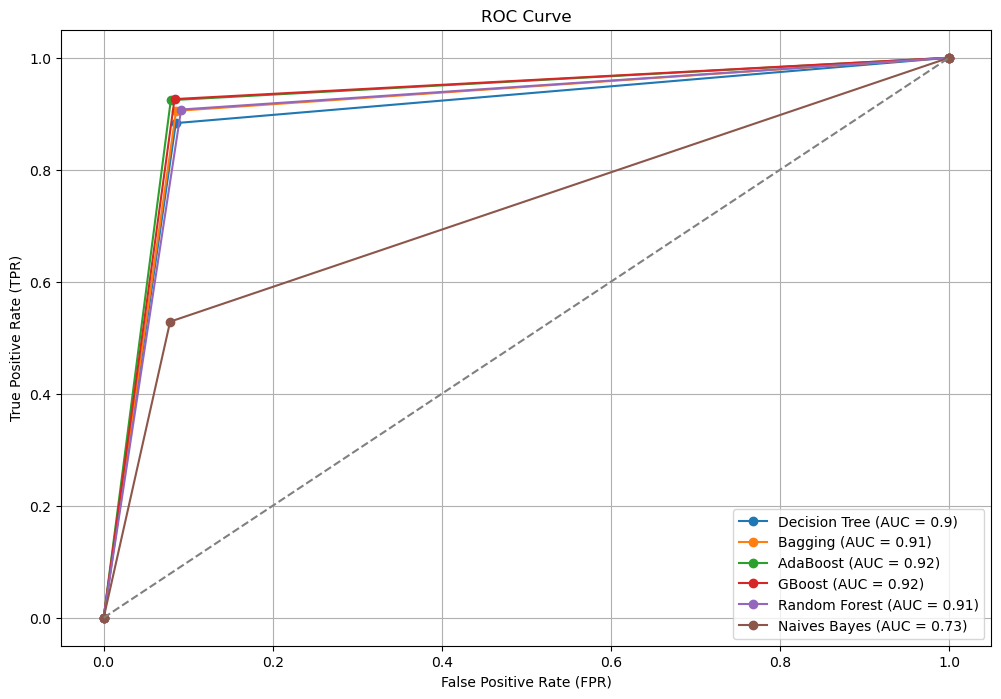

In [9]:
# Affichage de la courbe ROC
plt.figure(figsize=(12, 8))
plt.plot(fpr_val_dt, tpr_val_dt, marker='o', linestyle='-', label=f'Decision Tree (AUC = {roc_auc_dt})')
plt.plot(fpr_val_bg, tpr_val_bg, marker='o', linestyle='-', label=f'Bagging (AUC = {roc_auc_bg})')
plt.plot(fpr_val_ab, tpr_val_ab, marker='o', linestyle='-', label=f'AdaBoost (AUC = {roc_auc_ab})')
plt.plot(fpr_val_gb, tpr_val_gb, marker='o', linestyle='-', label=f'GBoost (AUC = {roc_auc_gb})')
plt.plot(fpr_val_rf, tpr_val_rf, marker='o', linestyle='-', label=f'Random Forest (AUC = {roc_auc_rf})')
plt.plot(fpr_val_nb, tpr_val_nb, marker='o', linestyle='-', label=f'Naives Bayes (AUC = {roc_auc_nb})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.grid()
plt.title("ROC Curve")
plt.legend()
plt.show()

### Conclusion

GBoost et AdaBoost se distinguent comme les meilleurs algorithmes pour la détection des utilisateurs pollueurs (classe 1), grâce à leur F1-score élevé, reflet d’un bon équilibre entre précision et rappel. 

Random Forest et Bagging offrent également un bon compromis entre performance et robustesse. 

En revanche, l’algorithme Naive Bayes s’avère mal adapté à ce jeu de données, ayant des difficultés à différencier correctement les classes.